## In this notebook I will load all the folds and predict the PET Images and then measure their metrics

In [2]:
%pip install nilearn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 6.0 MB/s eta 0:00:0000:010:01m
Note: you may need to restart the kernel to use updated packages.


In [266]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import nibabel as nib
import os
import glob
from os.path import join as opj
from mpl_toolkits.axes_grid1 import ImageGrid
from unet3D import *
from torchsummary import summary
import monai
from monai.transforms import *
from mpl_toolkits.axes_grid1 import ImageGrid
import ssim
import tqdm

from sklearn.model_selection import train_test_split

from torchvision.utils import make_grid
from sklearn.model_selection import KFold
import nilearn
import nibabel as nib
from nilearn import plotting,image
import shutil
from scipy.stats import pearsonr as corr
from scipy.stats import ttest_rel
import pandas as pd

In [210]:
class MRIPETDataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels,roi=(96,96,96), transform=None, target_transform=None,out_mask=True,return_path=True):
        self.paths = paths
        self.labels=labels
        self.transform = transform
        self.target_transform = target_transform
        self.roi=roi
        self.out_mask=out_mask
        self.return_path=return_path
        
    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        
        images_path=glob.glob(opj(self.paths[idx],"*.nii.gz"))
        t1_path=[i for i in images_path if "T1" in i][0]
        pet_path=[i for i in images_path if "_suv_" in i][0]
        
        t1=nib.load(t1_path)
        pet=nib.load(pet_path)
        
        affine=pet.affine
        
        assert t1.shape==pet.shape
        half_shape=[s//2 for s in t1.shape]
        half_roi=[s//2 for s in self.roi]
        dim_0_start=half_shape[0]-half_roi[0]
        dim_0_end=half_shape[0]+half_roi[0]

        dim_1_start=half_shape[1]-half_roi[1]
        dim_1_end=half_shape[1]+half_roi[1]

        dim_2_start=half_shape[2]-half_roi[2]
        dim_2_end=half_shape[2]+half_roi[2]
        try:
            t1=t1.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        try:
            pet=pet.dataobj[dim_0_start:dim_0_end,dim_1_start:dim_1_end,dim_2_start:dim_2_end]
        except Exception as e:
            print(e)
            print(f"[ERROR] {pet_path} created problems.")
        
        t1=torch.Tensor(np.expand_dims(t1,0))
        pet=torch.Tensor(np.expand_dims(pet,0))
        
        label=self.labels[idx]
        if self.transform:
            t1 = self.transform(t1)
        if self.target_transform:
            pet = self.target_transform(pet)
            
        if self.out_mask:
            mask=(t1>0)*1.
            if self.return_path:
                path=opj(self.paths[idx])
                return t1,pet,mask,label,path,affine
            else:
                return t1,pet,mask,label,affine
        else:
                         
            if self.return_path:
                path=opj(self.paths[idx])
                return t1,pet,label,path,affine
            else:
                return t1,pet, label,affine

In [47]:
base_path="/home/matteo/data/MRI-PET-AI/regressed_data"

cases=os.listdir(base_path)
exclude=['Scripts','temp','SubjectList.txt','Bay_7_Reconstruction_Log.xlsx','PBRKOA_KOA003_010818']

cases=[i for i in cases if i not in exclude]
label_dict={"HC":0, "CLB":1, "KOA":2}
inverse_label_dict={v:k for k,v in label_dict.items()}

labels=[]
for c in cases:
    cl=None
    if "HC" in c:
        cl="HC"
    elif "CLB" in c:
        cl="CLB"
    elif "KOA" in c:
        cl="KOA"
    if cl is not None:
        labels.append(label_dict[cl])
cases=[os.path.join(base_path,i) for i in cases if i not in exclude]

In [223]:
## make folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # Using KFold from scikit-learn

fold_indices = list(kf.split(cases))  # Generate indices for splitting the data

inputs=[]
outputs=[]
reference=[]
populations=[]
masks=[]

for fold in [0,1,2,3,4]:
    
    ## load data


    train_indices, test_indices = fold_indices[fold]  # Select the fold indices

    train_cases=np.array(cases)[train_indices]
    test_cases=np.array(cases)[test_indices]
    train_labels=np.array(labels)[train_indices]
    test_labels=np.array(labels)[test_indices]
    
    
    BS=1

    transform_mri=Compose([ScaleIntensityRangePercentiles(1,99,0,1)])
    transform_pet=Compose([ScaleIntensity(0,1)])

    test_dataset=MRIPETDataset(test_cases,test_labels,transform=transform_mri,target_transform=transform_pet)


    test_dataloader=torch.utils.data.DataLoader(test_dataset,batch_size=BS,shuffle=True)

    
    ## load model
    n_channels=32
    ch_mults=(1,1,1,1)
    is_attn=(False,False,False,True)
    n_blocks=1
    depthwise_separable=True

    device="cuda:0"
    model=UNet3D(image_channels=1,n_channels=n_channels,ch_mults=ch_mults,is_attn=is_attn,n_blocks=n_blocks,depthwise_separable=depthwise_separable)


    fold_dir=f"models_regressed/unet_t12pet_fold_{fold}"
    model.load_state_dict(torch.load(opj(fold_dir,f"unet_t12pet_fold_{fold}_final_fold_{fold}.pt")))

    model.to(device)
    print()
    
    
    ## predict
    inputs_fold=[]
    outputs_fold=[]
    reference_fold=[]
    populations_fold=[]
    masks_fold=[]
    
    os.makedirs(opj(fold_dir,"generated"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/structural"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/original"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/converted"),exist_ok=True)
    
    os.makedirs(opj(fold_dir,"generated/structural/CLB"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/structural/HC"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/structural/KOA"),exist_ok=True)


    os.makedirs(opj(fold_dir,"generated/original/CLB"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/original/HC"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/original/KOA"),exist_ok=True)

    os.makedirs(opj(fold_dir,"generated/converted/CLB"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/converted/HC"),exist_ok=True)
    os.makedirs(opj(fold_dir,"generated/converted/KOA"),exist_ok=True)

    with torch.no_grad():
        for x,y,m,l,path,affine in tqdm.tqdm(test_dataloader):
            affine=affine[0]
            inputs_fold.append(x)
            reference_fold.append(y)
            populations_fold.append(l)
            x=x.to(device)
            
            out=model(x).cpu()
            
            out=m*out
            outputs_fold.append(out)
            masks_fold.append(m)
            
            
            target_class=inverse_label_dict[l.item()]
            target_name=path[0].split("/")[-1]

            structural=nib.Nifti1Image(x.cpu().squeeze().numpy(),affine)
            nib.save(structural,f"{fold_dir}/generated/structural/{target_class}/{target_name}.nii.gz")


            pet_orig=nib.Nifti1Image(y.squeeze().numpy(),affine)
            nib.save(pet_orig,f"{fold_dir}/generated/original/{target_class}/{target_name}.nii.gz")


            pet_generated=nib.Nifti1Image(out.squeeze().numpy(),affine)
            nib.save(pet_generated,f"{fold_dir}/generated/converted/{target_class}/{target_name}.nii.gz")
            
        
        inputs_fold=torch.cat(inputs_fold,0)
        reference_fold=torch.cat(reference_fold,0)
        outputs_fold=torch.cat(outputs_fold,0)
        populations_fold=torch.cat(populations_fold,0)
        masks_fold=torch.cat(masks_fold,0)
        
        
    inputs.append(inputs_fold)
    outputs.append(outputs_fold)
    reference.append(reference_fold)
    populations.append(populations_fold)
    masks.append(masks_fold)
    

100%|███████████████████████████████████████████| 41/41 [00:24<00:00,  1.66it/s]


100%|███████████████████████████████████████████| 41/41 [00:24<00:00,  1.64it/s]


100%|███████████████████████████████████████████| 41/41 [00:24<00:00,  1.64it/s]


100%|███████████████████████████████████████████| 40/40 [00:24<00:00,  1.64it/s]


100%|███████████████████████████████████████████| 40/40 [00:24<00:00,  1.65it/s]


In [224]:
## Convert to MNI space

In [244]:
def convert_to_mni(fold_dir):

    FSLDIR="/usr/local/fsl/"

    structural_mni_path=f"{fold_dir}/generated/structural_mni"

    convert_to_mni=True
    print("Compute transformation for structural images")

    if convert_to_mni:

        os.makedirs(structural_mni_path,exist_ok=True)

        for subdir in os.listdir(f"{fold_dir}/generated/structural"):
            subdir_path=opj(f"{fold_dir}/generated/structural",subdir)
            filenames=os.listdir(subdir_path)
            for filename in tqdm.tqdm(filenames):

                #generate directory
                os.makedirs(opj(structural_mni_path,subdir),exist_ok=True)

                #compute inpute path and output
                in_file_path=opj(f"{fold_dir}/generated/structural",subdir,filename)

                ### LINEAR T1 to MNI
                outfilename=filename.replace(".nii.gz","_T1toMNIlin.nii.gz")
                outmatname=filename.replace(".nii.gz","_T1toMNIlin.mat")

                out_file_path=opj(structural_mni_path,subdir,outfilename)
                out_mat_path=opj(structural_mni_path,subdir,outmatname)

                !flirt -in {in_file_path} -ref {FSLDIR}/data/standard/MNI152_T1_2mm_brain.nii.gz -dof 12 -out {out_file_path} -omat {out_mat_path}


                ## NONLINEAR T1 to MNI
                config_fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.cnf")
                coef_name=filename.replace(".nii.gz","_T1toMNI_coef.nii.gz")
                warp_name=filename.replace(".nii.gz","_T1toMNI_warp.nii.gz")
                fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.nii.gz")

                config_fnirt_path=opj(structural_mni_path,subdir,config_fnirt_name)
                coef_path=opj(structural_mni_path,subdir,coef_name)
                warp_path=opj(structural_mni_path,subdir,warp_name)
                out_fnirt_path=opj(structural_mni_path,subdir,fnirt_name)

                !fnirt --in={in_file_path} --ref={FSLDIR}/data/standard/MNI152_T1_2mm_brain.nii.gz --aff={out_mat_path} --iout={out_fnirt_path} --cout={coef_path} --fout={warp_path}

    print("Process PET Images")
     
    if True:
        pet_mni=f"{fold_dir}/generated/pet_mni"
        pet_converted_mni=f"{fold_dir}/generated/converted_mni"
        os.makedirs(pet_mni,exist_ok=True)
        os.makedirs(pet_converted_mni,exist_ok=True)

        for subdir in os.listdir(f"{fold_dir}/generated/structural"):
            subdir_path=opj(f"{fold_dir}/generated/original",subdir)
            filenames=os.listdir(subdir_path)
            for filename in tqdm.tqdm(filenames):

                #generate directory
                os.makedirs(opj(pet_mni,subdir),exist_ok=True)
                os.makedirs(opj(pet_converted_mni,subdir),exist_ok=True)


                in_file_path=opj(f"{fold_dir}/generated/original",subdir,filename)
                in_file_converted_path=opj(f"{fold_dir}/generated/converted",subdir,filename)
                reference_t1_native_path=opj(f"{fold_dir}/generated/structural",subdir,filename)
                out_mat_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_T1.mat"))
                out_file_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_T1.nii.gz"))

                final_pet_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
                final_pet_convert_path=opj(pet_converted_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))


                warp_name=filename.replace(".nii.gz","_T1toMNI_warp.nii.gz")
                warp_path=opj(structural_mni_path,subdir,warp_name)
                #print(in_file_path,reference_t1_native_path)

                ### Linear PET to T1 to get mat file
                !flirt -in {in_file_path} -ref {reference_t1_native_path} -dof 12 -omat {out_mat_path} -out {out_file_path}

                ### NonLinear combination PET -> T1 native -> Standard


                !applywarp -i {in_file_path} -r {FSLDIR}/data/standard/MNI152_T1_2mm.nii.gz --premat={out_mat_path} -w {warp_path} -o {final_pet_path}
                !applywarp -i {in_file_converted_path} -r {FSLDIR}/data/standard/MNI152_T1_2mm.nii.gz --premat={out_mat_path} -w {warp_path} -o {final_pet_convert_path}

    
    print("Moving images to their final directories")
    


    pet_final_mni=f"{fold_dir}/generated/original_final_mni"
    pet_converted_final_mni=f"{fold_dir}/generated/converted_final_mni"
    structural_converted_final_mni=f"{fold_dir}/generated/structural_final_mni"

    all_mni_dir=opj(fold_dir,"generated","MNI")
    all_mni_structural_dir=opj(fold_dir,"generated","MNI","structural")
    all_mni_original_dir=opj(fold_dir,"generated","MNI","original")
    all_mni_converted_dir=opj(fold_dir,"generated","MNI","converted")

    os.makedirs(all_mni_dir,exist_ok=True)
    os.makedirs(all_mni_structural_dir,exist_ok=True)
    os.makedirs(all_mni_original_dir,exist_ok=True)
    os.makedirs(all_mni_converted_dir,exist_ok=True)


    for subdir in os.listdir(f"{fold_dir}/generated/structural"):
        subdir_path=opj(f"{fold_dir}/generated/original",subdir)
        filenames=os.listdir(subdir_path)

        print(filenames)
        for filename in tqdm.tqdm(filenames):
            os.makedirs(opj(pet_final_mni,subdir),exist_ok=True)
            os.makedirs(opj(pet_converted_final_mni,subdir),exist_ok=True)
            os.makedirs(opj(structural_converted_final_mni,subdir),exist_ok=True)

            fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.nii.gz")
            src_out_fnirt_path=opj(structural_mni_path,subdir,fnirt_name)

            src_final_pet_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            src_final_pet_convert_path=opj(pet_converted_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))

            dst_out_fnirt_path=opj(structural_converted_final_mni,subdir,fnirt_name)
            dst_final_pet_path=opj(pet_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            dst_final_pet_convert_path=opj(pet_converted_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))

            shutil.copy(src_out_fnirt_path,dst_out_fnirt_path)
            shutil.copy(src_final_pet_path,dst_final_pet_path) 
            shutil.copy(src_final_pet_convert_path,dst_final_pet_convert_path)



            ## all to MNI dir
            dst_structural=opj(all_mni_structural_dir,fnirt_name)
            dst_original_pet=opj(all_mni_original_dir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
            dst_converted_pet=opj(all_mni_converted_dir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))




            shutil.copy(src_out_fnirt_path,dst_structural)
            shutil.copy(src_final_pet_path,dst_original_pet) 
            shutil.copy(src_final_pet_convert_path,dst_converted_pet)



In [ ]:
do_mni=False
if do_mni:
    for fold in [0,1,2,3,4]:
        fold_dir=f"models_regressed/unet_t12pet_fold_{fold}"

        convert_to_mni(fold_dir)

Compute transformation for structural images


 55%|███████████████████████                   | 11/20 [42:52<35:04, 233.84s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is -0.000415432 -- 4.68055


 95%|██████████████████████████████████████  | 19/20 [1:09:42<03:36, 216.38s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00928229 -- 2.16381


 41%|█████████████████▋                         | 7/17 [24:33<33:38, 201.85s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00877563 -- 1.75948


 47%|████████████████████▏                      | 8/17 [31:22<40:09, 267.77s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00634674 -- 4.95057
Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00498459 -- 5.05146


 53%|██████████████████████▊                    | 9/17 [37:28<39:48, 298.50s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00603641 -- 4.49598


  0%|                                                     | 0/4 [00:00<?, ?it/s]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00808282 -- 1.58561


100%|████████████████████████████████████████████| 4/4 [20:22<00:00, 305.67s/it]


Process PET Images


100%|█████████████████████████████████████████████| 4/4 [00:26<00:00,  6.65s/it]


Moving images to their final directories
['PBRKOA_KOA039_121819.nii.gz', 'PBRKOA_KOA022_052119.nii.gz', 'PBRKOA_KOA018_051719.nii.gz', 'PBRKOA_KOA048_120121.nii.gz', 'PBRKOA_KOA022_041719.nii.gz', 'PBRKOA_KOA030_102820.nii.gz', 'PBRKOA_KOA010_100418.nii.gz', 'PBRKOA_KOA006_052919_correctID.nii.gz', 'PBRKOA_KOA037_012320.nii.gz', 'PBRKOA_KOA042_030420.nii.gz', 'PBRKOA_KOA055_012921.nii.gz', 'PBRKOA_KOA026_060619.nii.gz', 'PBRKOA_KOA045_072920.nii.gz', 'PBRKOA_KOA048_103020.nii.gz', 'PBRKOA_KOA031_091019.nii.gz', 'PBRKOA_KOA038_012721.nii.gz', 'PBRKOA_KOA058_031821.nii.gz', 'PBRKOA_KOA051_110521.nii.gz', 'PBRKOA_KOA038_011520.nii.gz', 'PBRKOA_KOA005_031518.nii.gz']


100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 92.01it/s]


['IGN_CLBP006_01.nii.gz', 'IGN_CLBP001_02.nii.gz', 'IGN_CLBP018_02.nii.gz', 'IGN_CLBP067_02.nii.gz', 'IGN_CLBP057_01.nii.gz', 'IGN_CLBP054_01.nii.gz', 'IGN_CLBP018_01.nii.gz', 'IGN_CLBP071_01.nii.gz', 'IGN_CLBP041_02.nii.gz', 'IGN_CLBP049_01.nii.gz', 'IGN_CLBP056_01.nii.gz', 'IGN_CLBP020_01.nii.gz', 'IGN_CLBP009_02.nii.gz', 'IGN_CLBP010_02.nii.gz', 'IGN_CLBP008_02.nii.gz', 'IGN_CLBP008_01_REDO.nii.gz', 'IGN_CLBP061_01.nii.gz']


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 127.54it/s]


['PBRKOA_HC017_041119.nii.gz', 'PBRKOA_HC010.nii.gz', 'PBRKOA_HC025_02.nii.gz', 'PBRKOA_HC026_01.nii.gz']


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 129.07it/s]


Compute transformation for structural images


 29%|████████████▋                              | 5/17 [18:09<44:58, 224.86s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is -0.000148389 -- 4.67021
Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00585876 -- 4.79141


 35%|███████████████▏                           | 6/17 [24:04<49:18, 268.97s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is -0.0163862 -- 2.25953


 41%|█████████████████▋                         | 7/17 [29:04<46:31, 279.11s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is -0.000526489 -- 5.05848
Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00304756 -- 5.2099


 47%|████████████████████▏                      | 8/17 [28:14<32:17, 215.23s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00462824 -- 1.95352


 88%|███████████████████████████████████▎    | 15/17 [1:00:55<09:13, 276.92s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00852929 -- 4.8948


100%|████████████████████████████████████████████| 7/7 [34:20<00:00, 294.41s/it]


Process PET Images


100%|█████████████████████████████████████████████| 7/7 [00:49<00:00,  7.11s/it]


Moving images to their final directories
['PBRKOA_KOA022_082720.nii.gz', 'PBRKOA_KOA025_090220.nii.gz', 'PBRKOA_KOA047_080420.nii.gz', 'PBRKOA_KOA011.nii.gz', 'PBRKOA_KOA040_012420.nii.gz', 'PBRKOA_KOA001_100918.nii.gz', 'PBRKOA_KOA003_011918.nii.gz', 'PBRKOA_KOA001_111418.nii.gz', 'PBRKOA_KOA031_102319.nii.gz', 'PBRKOA_KOA033_072621.nii.gz', 'PBRKOA_KOA049_012122.nii.gz', 'PBRKOA_KOA027_071619.nii.gz', 'PBRKOA_KOA059_042721.nii.gz', 'PBRKOA_KOA025_080619.nii.gz', 'PBRKOA_KOA030_092519.nii.gz', 'PBRKOA_KOA044_072921.nii.gz', 'PBRKOA_KOA040_031020.nii.gz']


100%|███████████████████████████████████████████| 17/17 [00:00<00:00, 90.73it/s]


['IGN_CLBP068_01.nii.gz', 'IGN_CLBP002_02.nii.gz', 'IGN_CLBP070_01.nii.gz', 'IGN_CLBP023_01.nii.gz', 'IGN_CLBP015_01.nii.gz', 'IGN_CLBP036_01.nii.gz', 'IGN_CLBP002_01.nii.gz', 'IGN_CLBP067_01.nii.gz', 'IGN_CLBP027_02.nii.gz', 'IGN_CLBP043_01.nii.gz', 'IGN_CLBP017_02.nii.gz', 'IGN_CLBP006_02.nii.gz', 'IGN_CLBP004_01.nii.gz', 'IGN_CLBP028_01.nii.gz', 'IGN_CLBP069_01.nii.gz', 'IGN_CLBP041_01.nii.gz', 'IGN_CLBP005_02.nii.gz']


100%|██████████████████████████████████████████| 17/17 [00:00<00:00, 137.21it/s]


['PBRKOA_HC043_01.nii.gz', 'PBRKOA_HC018_01.nii.gz', 'PBRKOA_HC011_090518.nii.gz', 'PBRKOA_HC022_01.nii.gz', 'PBRKOA_HC023_01.nii.gz', 'PBRKOA_HC013_100318.nii.gz', 'PBRKOA_HC002.nii.gz']


100%|████████████████████████████████████████████| 7/7 [00:00<00:00, 150.26it/s]


Compute transformation for structural images


 10%|████                                     | 2/20 [06:35<1:01:57, 206.52s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00968117 -- 2.57053
Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00884756 -- 2.80922


 25%|██████████▎                              | 5/20 [24:10<1:16:05, 304.38s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.0093095 -- 4.7701


 80%|████████████████████████████████        | 16/20 [1:07:06<14:24, 216.21s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is -0.00117809 -- 4.45262


 90%|████████████████████████████████████    | 18/20 [1:16:24<07:57, 238.51s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00970282 -- 2.28702


  7%|██▉                                      | 1/14 [06:20<1:22:25, 380.41s/it]

Warning, Jacobian not within prescribed range. Prescription is 0.01 -- 100 and obtained range is 0.00861353 -- 2.50655


 43%|██████████████████▊                         | 3/7 [15:26<20:59, 314.92s/it]

In [292]:
print("fine")

fine


In [245]:
# structural_mni_path=f"{fold_dir}/generated/structural_mni"
# pet_mni=f"{fold_dir}/generated/pet_mni"
# pet_converted_mni=f"{fold_dir}/generated/converted_mni"

# pet_final_mni=f"{fold_dir}/generated/original_final_mni"
# pet_converted_final_mni=f"{fold_dir}/generated/converted_final_mni"
# structural_converted_final_mni=f"{fold_dir}/generated/structural_final_mni"

# all_mni_dir=opj(fold_dir,"generated","MNI")
# all_mni_structural_dir=opj(fold_dir,"generated","MNI","structural")
# all_mni_original_dir=opj(fold_dir,"generated","MNI","original")
# all_mni_converted_dir=opj(fold_dir,"generated","MNI","converted")

# os.makedirs(all_mni_dir,exist_ok=True)
# os.makedirs(all_mni_structural_dir,exist_ok=True)
# os.makedirs(all_mni_original_dir,exist_ok=True)
# os.makedirs(all_mni_converted_dir,exist_ok=True)


# for subdir in os.listdir(f"{fold_dir}/generated/structural"):
#     subdir_path=opj(f"{fold_dir}/generated/original",subdir)
#     filenames=os.listdir(subdir_path)
    
#     print(filenames)
#     for filename in tqdm.tqdm(filenames):
#         os.makedirs(opj(pet_final_mni,subdir),exist_ok=True)
#         os.makedirs(opj(pet_converted_final_mni,subdir),exist_ok=True)
#         os.makedirs(opj(structural_converted_final_mni,subdir),exist_ok=True)

#         fnirt_name=filename.replace(".nii.gz","_T1_2_MNI152_2mm.nii.gz")
#         src_out_fnirt_path=opj(structural_mni_path,subdir,fnirt_name)

#         src_final_pet_path=opj(pet_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
#         src_final_pet_convert_path=opj(pet_converted_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))

#         dst_out_fnirt_path=opj(structural_converted_final_mni,subdir,fnirt_name)
#         dst_final_pet_path=opj(pet_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
#         dst_final_pet_convert_path=opj(pet_converted_final_mni,subdir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        
#         shutil.copy(src_out_fnirt_path,dst_out_fnirt_path)
#         shutil.copy(src_final_pet_path,dst_final_pet_path) 
#         shutil.copy(src_final_pet_convert_path,dst_final_pet_convert_path)

        
        
#         ## all to MNI dir
#         dst_structural=opj(all_mni_structural_dir,fnirt_name)
#         dst_original_pet=opj(all_mni_original_dir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
#         dst_converted_pet=opj(all_mni_converted_dir,filename.replace(".nii.gz","_PET_2_MNI.nii.gz"))
        

        
                
#         shutil.copy(src_out_fnirt_path,dst_structural)
#         shutil.copy(src_final_pet_path,dst_original_pet) 
#         shutil.copy(src_final_pet_convert_path,dst_converted_pet)
        

## Try to visualize some images

In [70]:
rnd_idx=np.random.randint(20)

example_t1=inputs[0][rnd_idx]
example_pet_pred=outputs[0][rnd_idx]
example_pet_true=reference[0][rnd_idx]
pop=inverse_label_dict[populations[0][rnd_idx].item()]
print(pop)
example_t1_nib=nib.Nifti1Image(example_t1.squeeze().numpy(),affine=np.eye(4))
example_pet_pred_nib=nib.Nifti1Image(example_pet_pred.squeeze().numpy(),affine=np.eye(4))
example_pet_true_nib=nib.Nifti1Image(example_pet_true.squeeze().numpy(),affine=np.eye(4))

example_pet_true_smoothed_nib = image.smooth_img(example_pet_true_nib, 3)

CLB


In [71]:
example_t1.shape

torch.Size([1, 96, 96, 96])

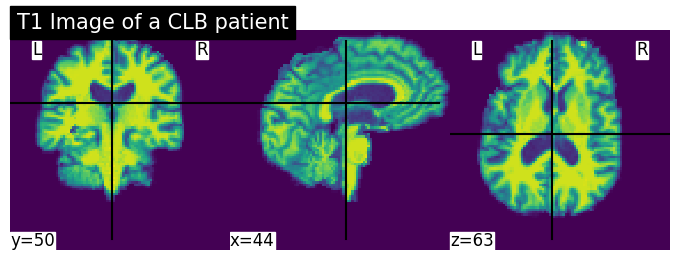

In [72]:
plotting.plot_img(example_t1_nib,title=f"T1 Image of a {pop} patient")

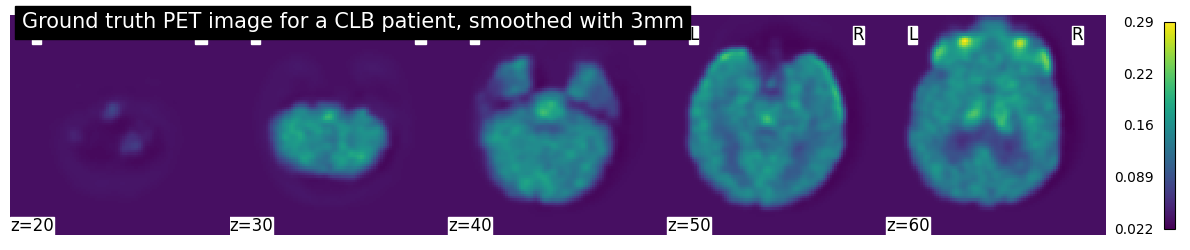

In [73]:
plotting.plot_img(example_pet_true_smoothed_nib,colorbar=True,display_mode="z",title=f"Ground truth PET image for a {pop} patient, smoothed with 3mm",cut_coords=range(20,70,10))

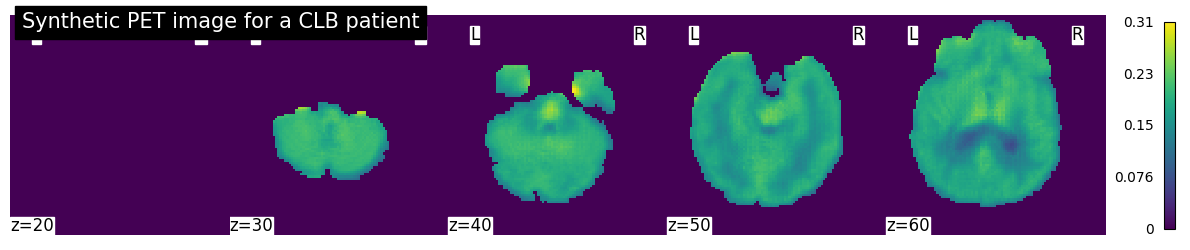

In [74]:
plotting.plot_img(example_pet_pred_nib,colorbar=True,display_mode="z",title=f"Synthetic PET image for a {pop} patient",cut_coords=range(20,70,10))

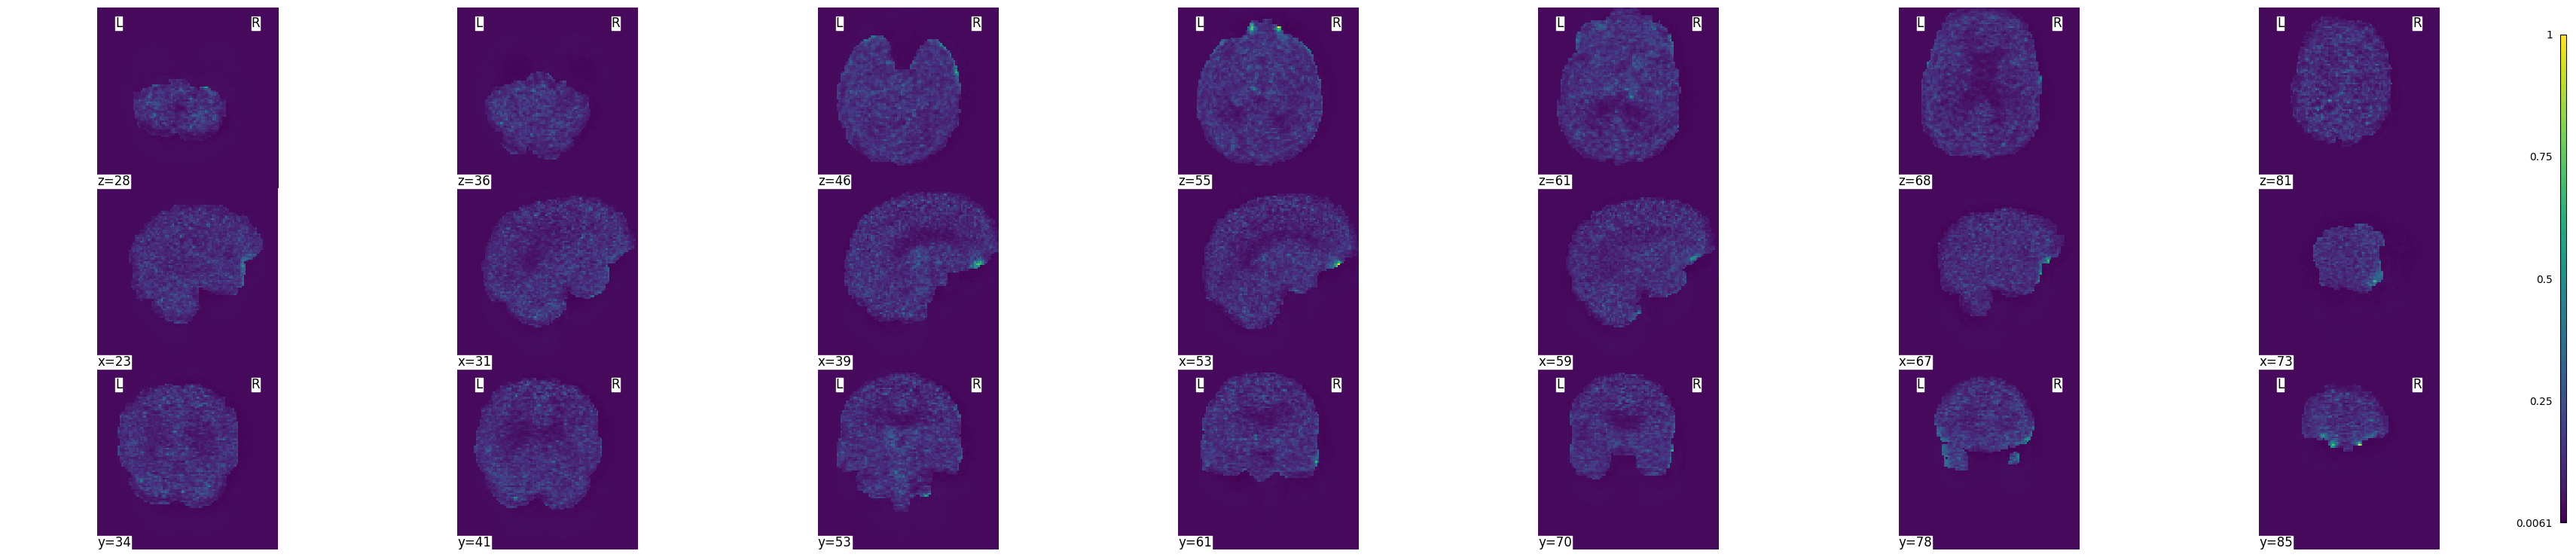

In [35]:
plotting.plot_img(example_pet_true_nib,colorbar=True,display_mode="mosaic")

## Load images 
TODO LAVORARE QUA!
- [x] Smooth images
- [x] Load Images
- [ ] Compute metrics

In [255]:
mask="/usr/local/fsl/data/standard/MNI152_T1_2mm_brain_mask.nii.gz"

mask=nib.load(mask)

In [256]:
dirs=[f"{fold_dir}/generated/original_final_mni",f"{fold_dir}/generated/original_smoothed_final_mni",f"{fold_dir}/generated/converted_final_mni"]

In [259]:
# original=[]
# smoothed=[]
# converted=[]
# for subdir in os.listdir(dirs[0]):
#     original+=glob.glob(os.path.join(dirs[0],subdir,"*.nii.gz"))
#     smoothed+=glob.glob(os.path.join(dirs[1],subdir,"*.nii.gz"))
#     converted+=glob.glob(os.path.join(dirs[2],subdir,"*.nii.gz"))
    
# original=[nib.load(i) for i in original]
# smoothed=[image.smooth_img(i, 3) for i in original]
# converted=[nib.load(i) for i in converted]

# original_data=[]
# smoothed_data=[]
# converted_data=[]


# for o,s,c in tqdm.tqdm(zip(original,smoothed,converted)):
#     original_data.append(o.get_fdata())
#     smoothed_data.append(s.get_fdata())
#     converted_data.append(c.get_fdata())
    
# original_data=np.array(original_data)
# smoothed_data=np.array(smoothed_data)
# converted_data=np.array(converted_data)
# affine=original[0].affine

40it [00:01, 28.00it/s]


In [258]:
def compute_cnr(image, mask, box_shape=(3,3,4), N=1000):
    """
    Compute the CNR (contrast-to-noise ratio) metric of an image given a mask and box shape.

    Args:
    image: 3D numpy array, input image
    mask: 3D numpy array, mask with 1 for voxels inside the region of interest and 0 for voxels outside
    box_shape: tuple, shape of the box to sample (default is (3,3,4))
    N: int, number of times to sample boxes (default is 1000)

    Returns:
    cnr: float, computed CNR value
    """

    # initialize lists to store mean and std of boxes
    mean_inside = []
    mean_outside = []
    std_inside = []
    std_outside = []
    cnr_list=[]

    # iterate N times
    for i in tqdm.tqdm(range(N)):
        # sample two boxes inside the mask
        box1, box2 = None, None
        while box1 is None:
            # sample random indices
            x, y, z = np.random.randint(box_shape[0]//2, image.shape[0]-box_shape[0]//2, 1)[0], np.random.randint(box_shape[1]//2, image.shape[1]-box_shape[1]//2, 1)[0], np.random.randint(box_shape[2]//2, image.shape[2]-box_shape[2]//2, 1)[0]
            # check if both boxes are inside the mask
            if np.sum(mask[x-box_shape[0]//2:x+box_shape[0]//2+1, y-box_shape[1]//2:y+box_shape[1]//2+1, z-box_shape[2]//2:z+box_shape[2]//2+1]) == box_shape[0]*box_shape[1]*box_shape[2]:
                box1 = image[x-box_shape[0]//2:x+box_shape[0]//2+1, y-box_shape[1]//2:y+box_shape[1]//2+1, z-box_shape[2]//2:z+box_shape[2]//2+1]
                
        while box2 is None:
            x, y, z = np.random.randint(box_shape[0]//2, image.shape[0]-box_shape[0]//2, 1)[0], np.random.randint(box_shape[1]//2, image.shape[1]-box_shape[1]//2, 1)[0], np.random.randint(box_shape[2]//2, image.shape[2]-box_shape[2]//2, 1)[0]
            if np.sum(mask[x-box_shape[0]//2:x+box_shape[0]//2+1, y-box_shape[1]//2:y+box_shape[1]//2+1, z-box_shape[2]//2:z+box_shape[2]//2+1]) == box_shape[0]*box_shape[1]*box_shape[2]:
                box2 = image[x-box_shape[0]//2:x+box_shape[0]//2+1, y-box_shape[1]//2:y+box_shape[1]//2+1, z-box_shape[2]//2:z+box_shape[2]//2+1]

        # compute mean and std of boxes
        mean1, std1 = np.mean(box1, dtype=np.float64), np.std(box1, dtype=np.float64)
        mean2, std2 = np.mean(box2, dtype=np.float64), np.std(box2, dtype=np.float64)
        # store values in appropriate lists
        mean_inside.append(mean1)
        mean_outside.append(mean2)
        std_inside.append(std1)
        std_outside.append(std2)
        
        cnr= np.abs(mean1-mean2)/np.sqrt(std1**2+std2**2)
        cnr_list.append(cnr)
        
    return cnr_list

[INFO] Running fold 0


41it [00:01, 25.93it/s]
/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in true_divide
  0%|                                                    | 0/91 [00:00<?, ?it/s]/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|███████████████████████████████████████| 1000/1000 [00:17<00:00, 56.95it/s]
/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:135: RuntimeWarning: invalid value encountered in true_divide
/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:136: RuntimeWarning: invalid value encountered in true_divide
100%|████

[INFO] Running fold 1


41it [00:01, 40.24it/s]
100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 12.56it/s]


[INFO] Running fold 2


41it [00:01, 40.45it/s]
100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 12.53it/s]


[INFO] Running fold 3


40it [00:00, 40.24it/s]
100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 12.84it/s]


[INFO] Running fold 4


40it [00:00, 40.40it/s]
100%|███████████████████████████████████████████| 21/21 [00:01<00:00, 12.79it/s]


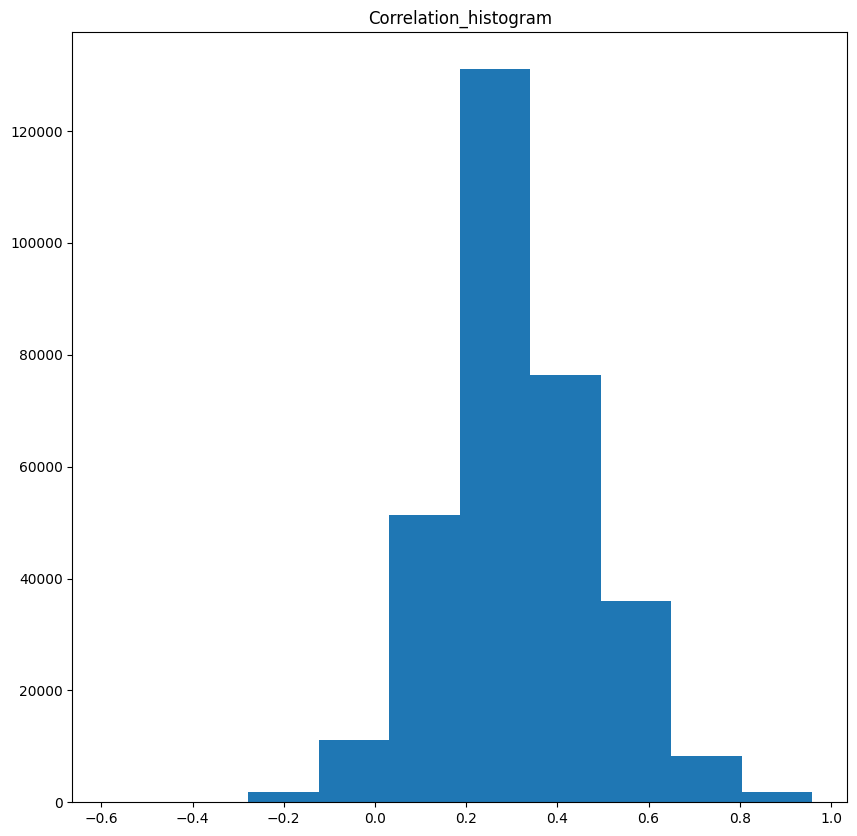

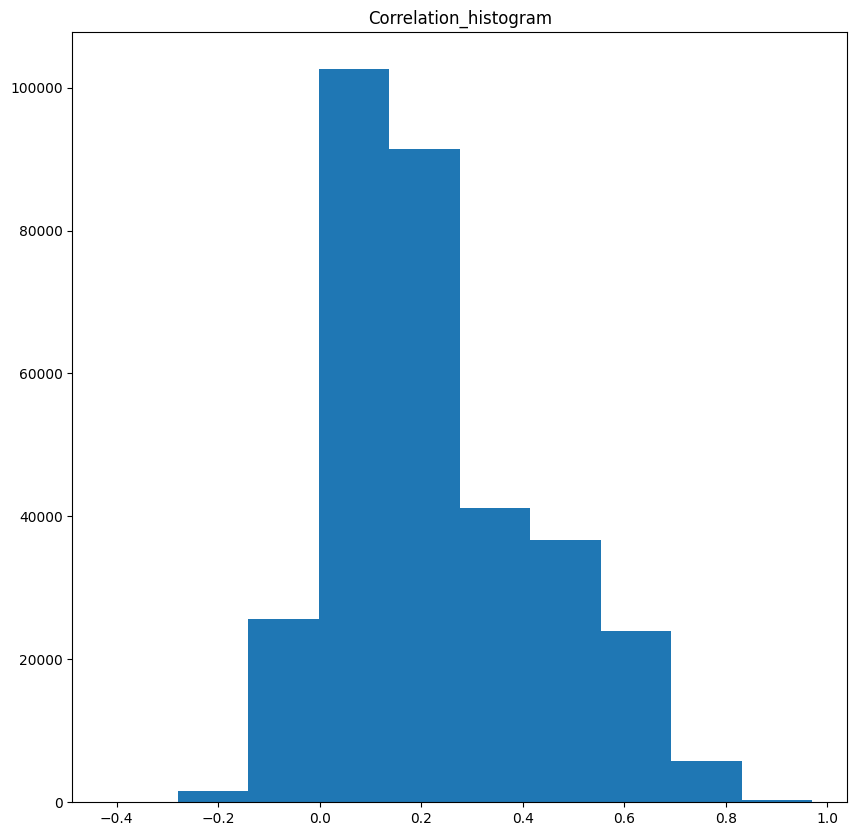

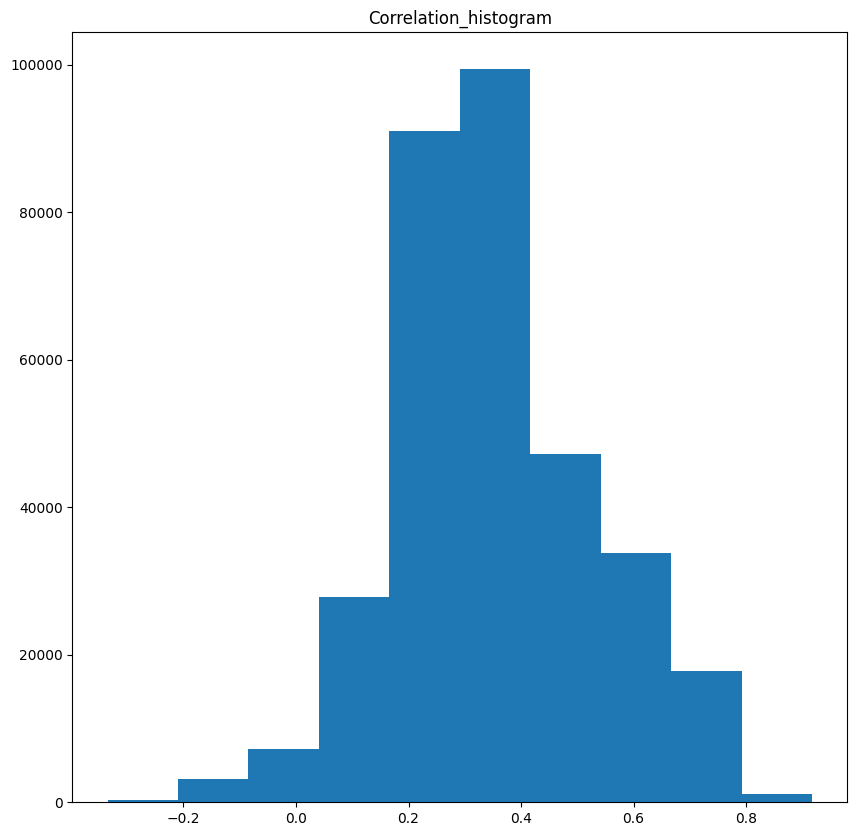

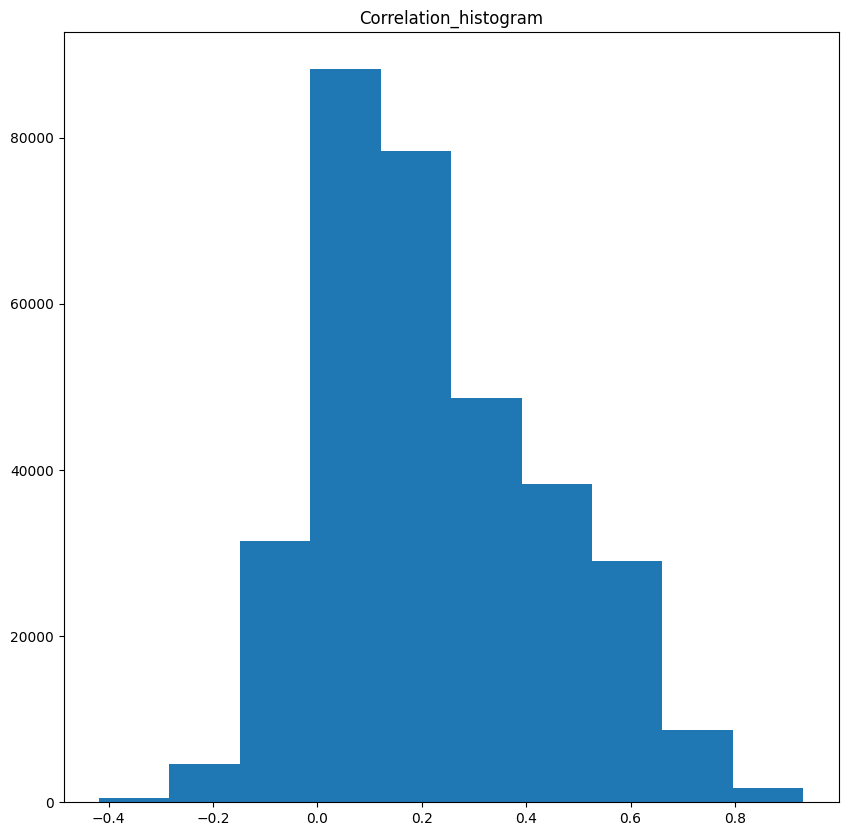

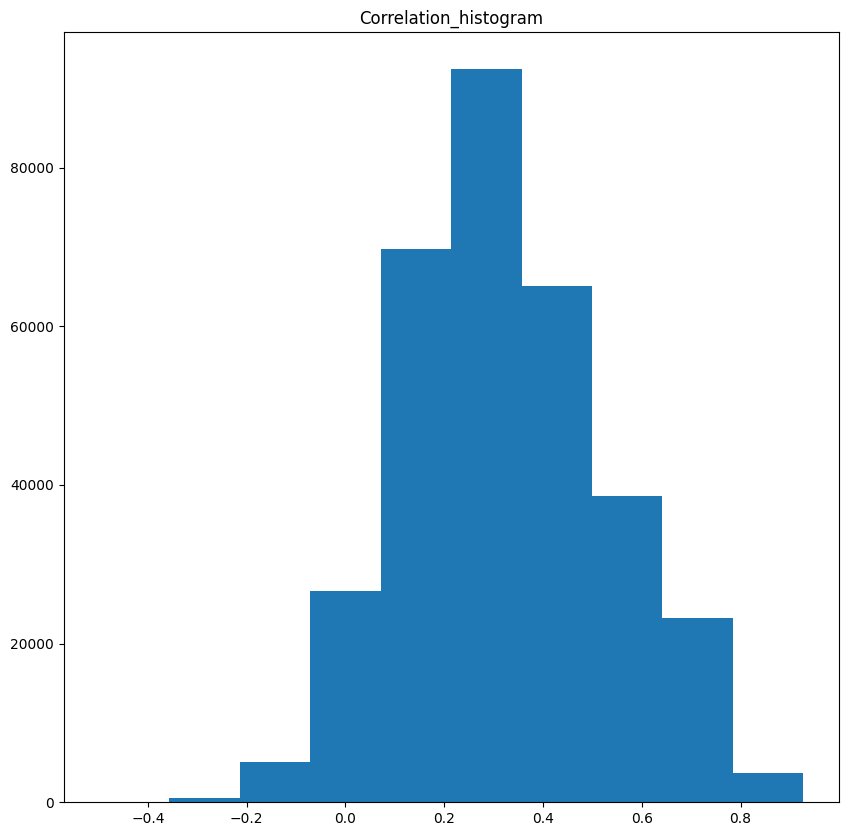

In [293]:

for fold in [0,1,2,3,4]:
    print(f"[INFO] Running fold {fold}")
    
    fold_dir=f"models_regressed/unet_t12pet_fold_{fold}"
    dirs=[f"{fold_dir}/generated/original_final_mni",f"{fold_dir}/generated/original_smoothed_final_mni",f"{fold_dir}/generated/converted_final_mni"]
    original=[]
    smoothed=[]
    converted=[]
    for subdir in os.listdir(dirs[0]):
        original+=glob.glob(os.path.join(dirs[0],subdir,"*.nii.gz"))
        smoothed+=glob.glob(os.path.join(dirs[1],subdir,"*.nii.gz"))
        converted+=glob.glob(os.path.join(dirs[2],subdir,"*.nii.gz"))

    original=[nib.load(i) for i in original]
    smoothed=[image.smooth_img(i, 3) for i in original]
    converted=[nib.load(i) for i in converted]

    original_data=[]
    smoothed_data=[]
    converted_data=[]


    for o,s,c in tqdm.tqdm(zip(original,smoothed,converted)):
        original_data.append(o.get_fdata())
        smoothed_data.append(s.get_fdata())
        converted_data.append(c.get_fdata())

    original_data=np.array(original_data)
    smoothed_data=np.array(smoothed_data)
    converted_data=np.array(converted_data)
    # affine=original[0].affine


    mse_original_converted=((original_data-converted_data)**2).mean(axis=0)
    mse_smoothed_converted=((smoothed_data-converted_data)**2).mean(axis=0)

    mse_original_converted_nii=nib.Nifti1Image(mse_original_converted,affine=affine)
    nib.save(mse_original_converted_nii,os.path.join(fold_dir,"mse_original_converted.nii.gz"))

    mse_smoothed_converted_nii=nib.Nifti1Image(mse_smoothed_converted,affine=affine)
    nib.save(mse_smoothed_converted_nii,os.path.join(fold_dir,"mse_smoothed_converted.nii.gz"))

    #normdiff

    normdiff_original_converted= ((original_data-converted_data)/(original_data+converted_data)).mean(axis=0)
    normdiff_smoothed_converted= ((smoothed_data-converted_data)/(smoothed_data+converted_data)).mean(axis=0)

    normdiff_original_converted_nii=nib.Nifti1Image(normdiff_original_converted,affine=affine)
    nib.save(normdiff_original_converted_nii,os.path.join(fold_dir,"normdiff_original_converted.nii.gz"))

    normdiff_smoothed_converted_nii=nib.Nifti1Image(normdiff_smoothed_converted,affine=affine)
    nib.save(normdiff_smoothed_converted_nii,os.path.join(fold_dir,"normdiff_smoothed_converted.nii.gz"))


    ## corr map

    corr_map=np.zeros(mask.shape)
    for x in tqdm.tqdm(range(mask.shape[0])):
        for y in range(mask.shape[1]):
            for z in range(mask.shape[2]):
                corr_map[x,y,z]=corr(smoothed_data[:,x,y,z],converted_data[:,x,y,z])[0]


    corr_map_nib=nib.Nifti1Image(corr_map,affine=affine)
    nib.save(corr_map_nib,os.path.join(fold_dir,"corr_map_nib.nii.gz"))

    fig, ax=plt.subplots(1,1,figsize=(10,10))
    ax.hist(corr_map.flatten())
    ax.set_title("Correlation_histogram")
    fig.savefig(opj(fold_dir,"corr.png"))

    corr_median=np.nanmedian(corr_map.flatten())
    corr_mean=np.nanmean(corr_map.flatten())
    corr_std=np.nanmean(corr_map.flatten())


    ## Compute CNR

    cnr_original=[compute_cnr(i,mask.get_fdata()) for i in original_data]
    cnr_smoothed=[compute_cnr(i,mask.get_fdata()) for i in smoothed_data]
    cnr_converted=[compute_cnr(i,mask.get_fdata()) for i in converted_data]

    pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
    pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
    pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))] 


    np.savetxt(opj(fold_dir,"cnr_original_dist.txt"),np.array(cnr_original))
    np.savetxt(opj(fold_dir,"cnr_smoothed_dist.txt"),np.array(cnr_smoothed))
    np.savetxt(opj(fold_dir,"cnr_converted_dist.txt"),np.array(cnr_converted))

    pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
    pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
    pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))]

    df_pvalues=pd.DataFrame(np.array([pval_original_converted,pval_smoothed_converted,pval_original_smoothed]).T, columns=["original_converted_p","smoothed_converted_p", "original_smoothed_p"])

    cnr_original_medians=np.percentile(np.array(cnr_original),50,axis=1)
    cnr_smoothed_medians=np.percentile(np.array(cnr_smoothed),50,axis=1)
    cnr_converted_medians=np.percentile(np.array(cnr_converted),50,axis=1)


    cnr_original_medians = cnr_original_medians[~np.isnan(cnr_original_medians)]
    cnr_smoothed_medians = cnr_smoothed_medians[~np.isnan(cnr_smoothed_medians)]
    cnr_converted_medians = cnr_converted_medians[~np.isnan(cnr_converted_medians)]


    ## LAVORARE QUI AGGIUNGERE LA CORRELATION MAP!

    atlas_path="HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz"
    atlas_indices_path="HarvardOxford-Subcortical.csv"

    df=pd.read_csv(atlas_indices_path)
    df["label"]=df.index+1
    df

    left_thal_label=4
    rigth_thal_label=15
    atlas=nib.load(atlas_path).get_fdata()


    mse=[]
    mse_smoothed=[]
    normdiff=[]
    normdiff_smoothed=[]
    cnr=[]
    cnr_smoothed=[]
    perc=[]
    perc_smoothed=[]
    corrs=[]

    x_mse=((original_data-converted_data)**2)
    x_mse_smoothed=((smoothed_data-converted_data)**2)

    x_normdiff=((original_data-converted_data)/(original_data+converted_data))
    x_normdiff_smoothed=((smoothed_data-converted_data)/(smoothed_data+converted_data))

    for label in tqdm.tqdm(df.label):
        mse.append(np.median(x_mse[:,atlas==label],axis=-1).mean())
        mse_smoothed.append(np.median(x_mse_smoothed[:,atlas==label],axis=-1).mean())

        normdiff.append(np.median(x_normdiff[:,atlas==label],axis=-1).mean())
        normdiff_smoothed.append(np.median(x_normdiff_smoothed[:,atlas==label],axis=-1).mean())

        #cnr
        roi_orig=original_data[:,atlas==label]
        roi_smooth=smoothed_data[:,atlas==label]
        roi_converted=converted_data[:,atlas==label]
        roi_corr=corr_map[atlas==label]

        perc_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_orig.mean(axis=-1)
        perc_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_smooth.mean(axis=-1)

        cnr_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_orig,roi_converted),axis=-1).std(axis=-1))
        cnr_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_smooth,roi_converted),axis=-1).std(axis=-1))

        cnr.append(cnr_values.mean())
        cnr_smoothed.append(cnr_smoothed_values.mean())

        perc.append(perc_values.mean())
        perc_smoothed.append(perc_smoothed_values.mean())

        corrs.append(roi_corr.mean())


    df["mse"]=mse
    df["mse_smoothed"]=mse_smoothed

    df["normdiff"]=normdiff
    df["normdiff_smoothed"]=normdiff_smoothed

    df["cnr"]=cnr
    df["cnr_smoothed"]=cnr

    df["perc"]=perc
    df["perc_smoothed"]=perc_smoothed
    df["corr"]=corrs

    df.to_csv(opj(fold_dir,"metrics.csv"),index=False)
    df


## Perform correaltion in Native Space

In [283]:
# cnr_smoothed=cnr_original

In [284]:

# pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))] 


# np.savetxt(opj(fold_dir,"cnr_original_dist.txt"),np.array(cnr_original))
# np.savetxt(opj(fold_dir,"cnr_smoothed_dist.txt"),np.array(cnr_smoothed))
# np.savetxt(opj(fold_dir,"cnr_converted_dist.txt"),np.array(cnr_converted))

# pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))]

# df_pvalues=pd.DataFrame(np.array([pval_original_converted,pval_smoothed_converted,pval_original_smoothed]).T, columns=["original_converted_p","smoothed_converted_p", "original_smoothed_p"])

# cnr_original_medians=np.percentile(np.array(cnr_original),50,axis=1)
# cnr_smoothed_medians=np.percentile(np.array(cnr_smoothed),50,axis=1)
# cnr_converted_medians=np.percentile(np.array(cnr_converted),50,axis=1)


# cnr_original_medians = cnr_original_medians[~np.isnan(cnr_original_medians)]
# cnr_smoothed_medians = cnr_smoothed_medians[~np.isnan(cnr_smoothed_medians)]
# cnr_converted_medians = cnr_converted_medians[~np.isnan(cnr_converted_medians)]


# ## LAVORARE QUI AGGIUNGERE LA CORRELATION MAP!

# atlas_path="HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz"
# atlas_indices_path="HarvardOxford-Subcortical.csv"

# df=pd.read_csv(atlas_indices_path)
# df["label"]=df.index+1
# df

# left_thal_label=4
# rigth_thal_label=15
# atlas=nib.load(atlas_path).get_fdata()


# mse=[]
# mse_smoothed=[]
# normdiff=[]
# normdiff_smoothed=[]
# cnr=[]
# cnr_smoothed=[]
# perc=[]
# perc_smoothed=[]
# corrs=[]

# x_mse=((original_data-converted_data)**2)
# x_mse_smoothed=((smoothed_data-converted_data)**2)

# x_normdiff=((original_data-converted_data)/(original_data+converted_data))
# x_normdiff_smoothed=((smoothed_data-converted_data)/(smoothed_data+converted_data))

# for label in tqdm.tqdm(df.label):
#     mse.append(np.median(x_mse[:,atlas==label],axis=-1).mean())
#     mse_smoothed.append(np.median(x_mse_smoothed[:,atlas==label],axis=-1).mean())
    
#     normdiff.append(np.median(x_normdiff[:,atlas==label],axis=-1).mean())
#     normdiff_smoothed.append(np.median(x_normdiff_smoothed[:,atlas==label],axis=-1).mean())
    
#     #cnr
#     roi_orig=original_data[:,atlas==label]
#     roi_smooth=smoothed_data[:,atlas==label]
#     roi_converted=converted_data[:,atlas==label]
#     roi_corr=corr_map[atlas==label]
    
#     perc_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_orig.mean(axis=-1)
#     perc_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_smooth.mean(axis=-1)
    
#     cnr_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_orig,roi_converted),axis=-1).std(axis=-1))
#     cnr_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_smooth,roi_converted),axis=-1).std(axis=-1))
    
#     cnr.append(cnr_values.mean())
#     cnr_smoothed.append(cnr_smoothed_values.mean())
                                                                                 
#     perc.append(perc_values.mean())
#     perc_smoothed.append(perc_smoothed_values.mean())
                                                                            
#     corrs.append(roi_corr.mean())

        
# df["mse"]=mse
# df["mse_smoothed"]=mse_smoothed

# df["normdiff"]=normdiff
# df["normdiff_smoothed"]=normdiff_smoothed

# df["cnr"]=cnr
# df["cnr_smoothed"]=cnr

# df["perc"]=perc
# df["perc_smoothed"]=perc_smoothed
# df["corr"]=corrs

# df.to_csv(opj(fold_dir,"metrics.csv"),index=False)
# df
        

/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide
/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: invalid value encountered in true_divide
100%|███████████████████████████████████████████| 21/21 [00:02<00:00, 10.08it/s]


,index,region,label,mse,mse_smoothed,normdiff,normdiff_smoothed,cnr,cnr_smoothed,perc,perc_smoothed,corr
0,0,Left Cerebral White Matter,1,0.002718,0.002449,NaN,-0.009510,-0.043245,-0.043245,-0.037467,-0.034990,0.206828
1,1,Left Cerebral Cortex,2,0.002959,0.002645,NaN,NaN,0.311467,0.311467,0.066749,0.062080,0.296335
2,2,Left Lateral Ventricle,3,0.001683,0.001424,-0.046014,-0.029896,-0.189355,-0.189355,-0.088859,-0.071566,0.507863
3,3,Left Thalamus,4,0.003754,0.003262,-0.002518,0.001032,0.070332,0.070332,-0.005345,-0.010990,0.289461
4,4,Left Caudate,5,0.002491,0.002148,-0.019480,-0.015286,-0.051194,-0.051194,-0.047434,-0.052706,0.226559
5,5,Left Putamen,6,0.003750,0.003410,-0.008590,-0.002474,0.034703,0.034703,-0.024570,-0.024826,0.297573
6,6,Left Pallidum,7,0.003732,0.003367,0.004084,0.009231,0.153913,0.153913,0.006501,0.003763,0.375930
7,7,Brain-Stem,8,0.003678,0.003310,0.008531,0.013518,0.152760,0.152760,0.021805,0.018994,0.331334
8,8,Left Hippocampus,9,0.002976,0.002627,-0.005068,-0.000423,0.077459,0.077459,-0.010092,-0.012059,0.312117
9,9,Left Amygdala,10,0.003402,0.003059,0.009750,0.013862,0.195369,0.195369,0.014035,0.009658,0.287812


In [287]:
df.mean()

/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


index                10.000000
label                11.000000
mse                   0.003187
mse_smoothed          0.002865
normdiff             -0.004633
normdiff_smoothed     0.000604
cnr                   0.086283
cnr_smoothed          0.086283
perc                 -0.007918
perc_smoothed        -0.008671
corr                  0.315461
dtype: float64

### Measure some metrics for each one of the folds

In [101]:
# ## LAVORARE QUI DEVE DIVENTARE UN CICLO FOR SU TUTTI I FOLD

# original_data=reference[fold]
# converted_data=outputs[fold]
# smoothed_data=torch.stack([smoothing(i) for i in original_data])
# masks_data=masks[fold]


# print("measuring classic metrics")
# mse_original_converted=((original_data-converted_data)**2).mean(axis=0)
# mse_smoothed_converted=((smoothed_data-converted_data)**2).mean(axis=0)


# mse_original_converted_nii=nib.Nifti1Image(mse_original_converted.numpy(),affine=np.eye(4))
# nib.save(mse_original_converted_nii,os.path.join(fold_dir,"mse_original_converted.nii.gz"))

# mse_smoothed_converted_nii=nib.Nifti1Image(mse_smoothed_converted.numpy(),affine=np.eye(4))
# nib.save(mse_smoothed_converted_nii,os.path.join(fold_dir,"mse_smoothed_converted.nii.gz"))


# #normdiff

# normdiff_original_converted= ((original_data-converted_data)/(original_data+converted_data)).mean(axis=0)
# normdiff_smoothed_converted= ((smoothed_data-converted_data)/(smoothed_data+converted_data)).mean(axis=0)

# normdiff_original_converted_nii=nib.Nifti1Image(normdiff_original_converted.numpy(),affine=np.eye(4))
# nib.save(normdiff_original_converted_nii,os.path.join(fold_dir,"normdiff_original_converted.nii.gz"))

# normdiff_smoothed_converted_nii=nib.Nifti1Image(normdiff_smoothed_converted.numpy(),affine=np.eye(4))
# nib.save(normdiff_smoothed_converted_nii,os.path.join(fold_dir,"normdiff_smoothed_converted.nii.gz"))

# print("measuring correlation")

# corr_map=np.zeros((96,96,96))
# for x in tqdm.tqdm(range(96)):
#     for y in range(96):
#         for z in range(96):
#             corr_map[x,y,z]=corr(smoothed_data[:,0,x,y,z],converted_data[:,0,x,y,z])[0]
            
            
# corr_map_nib=nib.Nifti1Image(corr_map,affine=np.eye(4))
# nib.save(corr_map_nib,os.path.join(fold_dir,"corr_map_nib.nii.gz"))

# fig, ax=plt.subplot(1,1,figsize=(10,10))
# ax.hist(corr_map.flatten())
# ax.set_title("Correlation_histogram")
# fig.savefig(opj(fold_dir,"corr.png"))

# corr_median=np.nanmedian(corr_map.flatten())
# corr_mean=np.nanmean(corr_map.flatten())
# corr_std=np.nanmean(corr_map.flatten())

# print("measuring CNR")

# converted_data_nib=[nib.Nifti1Image(i.squeeze().numpy(),affine=np.eye(4)) for i in converted_data]
# original_data_nib=[nib.Nifti1Image(i.squeeze().numpy(),affine=np.eye(4)) for i in original_data]
# smoothed_data_nib=[nib.Nifti1Image(i.squeeze().numpy(),affine=np.eye(4)) for i in smoothed_data]
# masks_data_nib=[nib.Nifti1Image(i.squeeze().numpy().astype("int"),affine=np.eye(4)) for i in masks_data]


# cnr_original=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(original_data_nib,masks_data_nib)]
# cnr_smoothed=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(smoothed_data,masks_data_nib)]
# cnr_converted=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(converted_data,masks_data_nib)]



# pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))] 


# np.savetxt(opj(fold_dir,"cnr_original_dist.txt"),np.array(cnr_original))
# np.savetxt(opj(fold_dir,"cnr_smoothed_dist.txt"),np.array(cnr_smoothed))
# np.savetxt(opj(fold_dir,"cnr_converted_dist.txt"),np.array(cnr_converted))

# pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))]

# df_pvalues=pd.DataFrame(np.array([pval_original_converted,pval_smoothed_converted,pval_original_smoothed]).T, columns=["original_converted_p","smoothed_converted_p", "original_smoothed_p"])

# cnr_original_medians=np.percentile(np.array(cnr_original),50,axis=1)
# cnr_smoothed_medians=np.percentile(np.array(cnr_smoothed),50,axis=1)
# cnr_converted_medians=np.percentile(np.array(cnr_converted),50,axis=1)


# cnr_original_medians = cnr_original_medians[~np.isnan(cnr_original_medians)]
# cnr_smoothed_medians = cnr_smoothed_medians[~np.isnan(cnr_smoothed_medians)]
# cnr_converted_medians = cnr_converted_medians[~np.isnan(cnr_converted_medians)]


# ## LAVORARE QUI AGGIUNGERE LA CORRELATION MAP!

# atlas_path="HarvardOxford/HarvardOxford-sub-maxprob-thr25-2mm.nii.gz"
# atlas_indices_path="HarvardOxford-Subcortical.csv"

# df=pd.read_csv(atlas_indices_path)
# df["label"]=df.index+1
# df

# left_thal_label=4
# rigth_thal_label=15
# atlas=nib.load(atlas_path).get_fdata()


# mse=[]
# mse_smoothed=[]
# normdiff=[]
# normdiff_smoothed=[]
# cnr=[]
# cnr_smoothed=[]
# perc=[]
# perc_smoothed=[]

# x_mse=((original_data-converted_data)**2)
# x_mse_smoothed=((smoothed_data-converted_data)**2)

# x_normdiff=((original_data-converted_data)/(original_data+converted_data))
# x_normdiff_smoothed=((smoothed_data-converted_data)/(smoothed_data+converted_data))

# for label in tqdm.tqdm(df.label):
#     mse.append(np.median(x_mse[:,atlas==label],axis=-1).mean())
#     mse_smoothed.append(np.median(x_mse_smoothed[:,atlas==label],axis=-1).mean())
    
#     normdiff.append(np.median(x_normdiff[:,atlas==label],axis=-1).mean())
#     normdiff_smoothed.append(np.median(x_normdiff_smoothed[:,atlas==label],axis=-1).mean())
    
#     #cnr
#     roi_orig=original_data[:,atlas==label]
#     roi_smooth=smoothed_data[:,atlas==label]
#     roi_converted=converted_data[:,atlas==label]
    
#     perc_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_orig.mean(axis=-1)
#     perc_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/roi_smooth.mean(axis=-1)
    
#     cnr_values=(roi_orig.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_orig,roi_converted),axis=-1).std(axis=-1))
#     cnr_smoothed_values=(roi_smooth.mean(axis=-1)-roi_converted.mean(axis=-1))/(np.concatenate((roi_smooth,roi_converted),axis=-1).std(axis=-1))
    
#     cnr.append(cnr_values.mean())
#     cnr_smoothed.append(cnr_smoothed_values.mean())
                                                                                 
#     perc.append(perc_values.mean())
#     perc_smoothed.append(perc_smoothed_values.mean())
                                                                            


        
# df["mse"]=mse
# df["mse_smoothed"]=mse_smoothed

# df["normdiff"]=normdiff
# df["normdiff_smoothed"]=normdiff_smoothed

# df["cnr"]=cnr
# df["cnr_smoothed"]=cnr

# df["perc"]=perc
# df["perc_smoothed"]=perc_smoothed

# df
        

/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  after removing the cwd from sys.path.


In [199]:
# cnr_original=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(original_data_nib,masks_data_nib)]
# cnr_smoothed=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(smoothed_data,masks_data_nib)]
# cnr_converted=[compute_cnr(i.get_fdata(),mask.get_fdata()) for i,mask in zip(converted_data,masks_data_nib)]

  8%|███▎                                     | 81/1000 [00:01<00:16, 55.52it/s]


KeyboardInterrupt: 

In [201]:
# corr_map=np.zeros((96,96,96))
# for x in tqdm.tqdm(range(96)):
#     for y in range(96):
#         for z in range(96):
#             corr_map[x,y,z]=corr(smoothed_data[:,0,x,y,z],converted_data[:,0,x,y,z])[0]

  0%|                                                    | 0/96 [00:00<?, ?it/s]/home/matteo/anaconda3/envs/ai/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|███████████████████████████████████████████| 96/96 [01:40<00:00,  1.04s/it]


In [200]:
# x,y,z=(48,48,48)
# corr(smoothed_data[:,0,x,y,z],converted_data[:,0,x,y,z])[0]

0.17360748222413114

In [158]:
# corr_map=np.nan_to_num(corr_map)

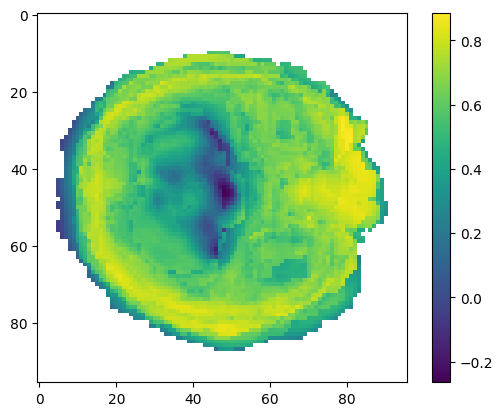

In [203]:
# plt.imshow(corr_map[:,:,45])
# plt.colorbar()

(array([7.00000e+01, 2.58000e+02, 1.85800e+03, 6.98100e+03, 1.71280e+04,
        3.28470e+04, 5.73780e+04, 7.66390e+04, 1.19091e+05, 3.58050e+04]),
 array([-0.33688329, -0.20871281, -0.08054233,  0.04762815,  0.17579863,
         0.30396912,  0.4321396 ,  0.56031008,  0.68848056,  0.81665104,
         0.94482152]),
 <BarContainer object of 10 artists>)

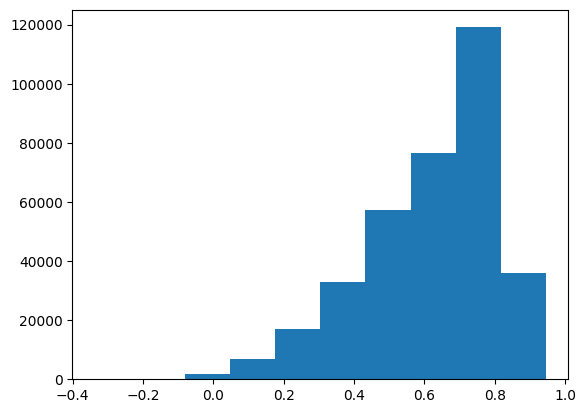

(0.6607847482906105, 0.6157324970791471, 0.18717615143865474)

In [ ]:
# pval_original_converted=[ttest_rel(cnr_original[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_smoothed_converted=[ttest_rel(cnr_smoothed[i],cnr_converted[i])[-1] for i in range(len(cnr_original))]
# pval_original_smoothed=[ttest_rel(cnr_original[i],cnr_smoothed[i])[-1] for i in range(len(cnr_original))] 


# np.savetxt("cnr_original_dist.txt",np.array(cnr_original))
# np.savetxt("cnr_smoothed_dist.txt",np.array(cnr_smoothed))
# np.savetxt("cnr_converted_dist.txt",np.array(cnr_converted))


  0%|                                                  | 0/1000 [00:06<?, ?it/s]


KeyboardInterrupt: 

In [136]:
# image=original_data[fold].numpy().squeeze()
# mask=masks[fold].numpy().squeeze()[0]


 22%|████████▋                               | 217/1000 [00:03<00:13, 56.27it/s]


KeyboardInterrupt: 

In [121]:
# np.random.randint(box_shape[0]//2, image.shape[0]-box_shape[0]//2, 1)[0],
# np.random.randint(box_shape[1]//2, image.shape[1]-box_shape[1]//2, 1)[0],
# np.random.randint(box_shape[2]//2, image.shape[2]-box_shape[2]//2, 1)[0]

19

In [120]:
# image.shape

(96, 96, 96)